In [2]:
!pip install -U imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/eb/aa/eba717a14df36f0b6f000ebfaf24c3189cd7987130f66cc3513efead8c2a/imbalanced_learn-0.6.1-py3-none-any.whl


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import precision_recall_curve
from collections import Counter
# from tqdm import tqdm_notebook as tqdm
# tqdm().pandas()
import json
import pickle
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model
from sklearn.metrics import log_loss
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
import tensorflow as tf
import random
import os
from imblearn.over_sampling import SMOTE

from keras import backend as K
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Read data

In [ ]:
with open("./data/service1906_1506.json") as of:
    data = json.load(of)

In [ ]:
computes = [c for c in data.keys() if c!="timespan"]
variables = [v for v in data[computes[0]] if v!='index' and v!='arrJob_scheduling']

In [4]:
#Check empty array
def getEmptyArr(data, c):
    cObj = data[c]
    cDf = pd.DataFrame()
    cDf['compute'] = [c for _ in data['timespan']]
    cDf['timespan'] = data['timespan']
    for v in variables:
        vArr = np.array(cObj[v])
        if len(vArr)==0:
            print('c=', c)
            print('v=', v)
for c in computes:
    getEmptyArr(data, c)

c= compute-1-26
v= arrTemperature


In [5]:
def addTarget(cDf, predictedVar, predictedStep):
    cDf[target] = cDf[predictedVar].shift(-predictedStep)
    cDf.dropna(inplace=True)

In [6]:
def getComputeDf(data, c, predictedVar, predictedStep):
    cObj = data[c]
    cDf = pd.DataFrame()
    cDf['compute'] = [c for _ in data['timespan']]
    cDf['timespan'] = data['timespan']
    for v in variables:
        vArr = np.array(cObj[v])
        if len(vArr)==0:
            return None
        else:
            for i in range(len(vArr[0])):
                cDf[v+str(i)] = vArr[:, i]
    cDf['timespan'] = pd.to_datetime(cDf['timespan'])
    addTarget(cDf, predictedVar, predictedStep)
    return cDf

In [7]:
predictedVar = 'arrTemperature0'
target = predictedVar + "_target"
predictedSteps = 12
df = pd.concat([x for x in [getComputeDf(data, c, predictedVar, predictedSteps) for c in computes] if type(x)!="NoneType"])

In [8]:
df = df.reset_index().drop('index', axis=1)

In [ ]:
df.head(10)

In [9]:
features = [x for x in df.columns if x not in ['compute', 'timespan', 'arrTemperature0_target']]

# Plot and see data distribution

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
def plotAttrDataOfId(data, compute, features):
    plt.figure(figsize=(30, 20))
#     for i, v in enumerate(features):
    for i, v in enumerate(features[0:1]):
        plt.subplot(10, 3, i+1)
        cDf = df[df['compute']==compute]
        plt.plot(cDf['timespan'], cDf[v])
        plt.title(v)
        plt.tight_layout()

In [ ]:
len(computes)

In [ ]:
df[df['compute']== 'compute-1-10'].timespan.min()

In [ ]:
df[df['compute']== 'compute-1-10'].timespan.max()

In [12]:
computes_df_list = [df[df['compute']== x].arrTemperature0.reset_index(drop=True) for x in computes]
time= df[df['compute']== computes[0]].timespan
computes_df = pd.concat([time, *computes_df_list], axis=1)
computes_df

,timespan,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,...,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0,arrTemperature0
0,2019-06-09 00:00:00+00:00,73,42,49,58,38,44,46,48,82,...,78,86,42,41,85,73,81,65,86,38
1,2019-06-09 00:05:00+00:00,73,42,49,58,38,44,46,48,82,...,79,86,42,41,85,72,80,65,85,38
2,2019-06-09 00:10:00+00:00,73,42,49,58,38,44,46,48,82,...,79,86,42,41,84,72,81,65,86,38
3,2019-06-09 00:15:00+00:00,73,42,49,58,38,44,46,48,81,...,78,86,41,41,84,73,81,66,87,38
4,2019-06-09 00:20:00+00:00,73,42,49,58,38,44,46,47,82,...,79,86,42,41,85,73,82,65,86,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,2019-06-15 22:35:00+00:00,42,54,64,86,58,74,47,40,48,...,40,44,48,49,64,57,51,52,61,50
2000,2019-06-15 22:40:00+00:00,42,55,64,86,59,75,47,40,48,...,41,44,48,49,64,57,50,52,61,50
2001,2019-06-15 22:45:00+00:00,42,54,64,86,58,76,47,40,48,...,41,44,48,49,64,58,50,52,61,50
2002,2019-06-15 22:50:00+00:00,42,55,64,86,59,76,47,40,48,...,40,44,48,48,64,57,50,52,61,50


In [13]:
computes_df.columns = ["time_span"] + ["arrTemperature0_" + str(i) for i in range(1, len(computes_df.columns ))]

In [19]:
computes_df.to_csv("computes_df.csv" , index=False)

In [20]:
computes_df.shape

(2012, 468)

In [14]:
computes_df_some = computes_df[["arrTemperature0_" + str(i) for i in range(1, len(computes_df.columns )) if i%30 == 0]]
computes_df_some.head()

,arrTemperature0_30,arrTemperature0_60,arrTemperature0_90,arrTemperature0_120,arrTemperature0_150,arrTemperature0_180,arrTemperature0_210,arrTemperature0_240,arrTemperature0_270,arrTemperature0_300,arrTemperature0_330,arrTemperature0_360,arrTemperature0_390,arrTemperature0_420,arrTemperature0_450
0,39,42,73,32,65,38,36,34,77,74,40,41,48,48,58
1,39,42,72,32,65,38,35,34,75,74,40,41,48,48,58
2,39,42,73,32,65,38,35,35,76,75,40,41,48,48,61
3,39,42,72,32,65,38,35,35,77,74,40,41,48,48,59
4,39,42,73,32,65,38,35,35,75,74,40,41,48,48,58


In [22]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(computes_df_some, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile.to_file(output_file="your_report.html")


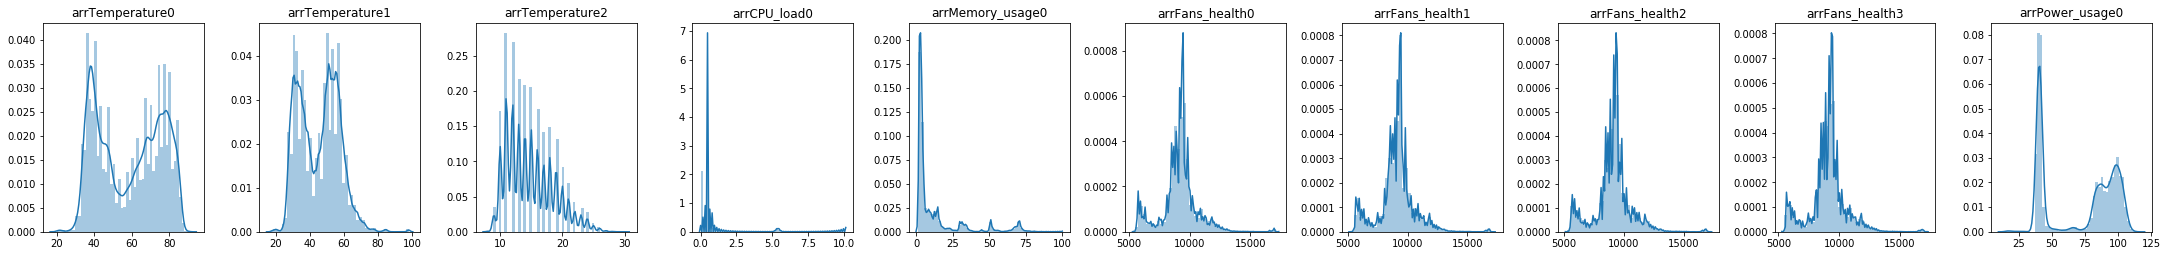

In [23]:
def plotDataDistribution(data, features):
    plt.figure(figsize=(30, 10))
    for i, v in enumerate(features):
        plt.subplot(3, 10, i+1)
        sns.distplot(list(data[v].values))
        plt.title(v)
    plt.tight_layout()
    
plotDataDistribution(df, features)

# Generate sequences
May need to fill forward (time sampling)

In [16]:
X_dfs_train = []
y_raw_train = []


X_dfs_test = []
y_raw_test = []

test_size = 0.2
sequenceSteps = 12

label = 'arrTemperature0'

for compute in (computes):
    cDf = df[df['compute']==compute].drop(columns=target)
    if(len(cDf) > sequenceSteps):
        for step_i in range(0, len(cDf) - sequenceSteps):
            
            if step_i < len(cDf)*(1-test_size):
                X_dfs_train.append(cDf.iloc[step_i:step_i+sequenceSteps])
                y_raw_train.append(cDf.iloc[step_i+sequenceSteps][label] - cDf.iloc[step_i+sequenceSteps-1][label])
            else:
                X_dfs_test.append(cDf.iloc[step_i:step_i+sequenceSteps])
                y_raw_test.append(cDf.iloc[step_i+sequenceSteps][label] - cDf.iloc[step_i+sequenceSteps-1][label])

In [18]:
X_dfs_train[249]

,compute,timespan,arrTemperature0,arrTemperature1,arrTemperature2,arrCPU_load0,arrMemory_usage0,arrFans_health0,arrFans_health1,arrFans_health2,arrFans_health3,arrPower_usage0
249,compute-1-1,2019-06-09 20:45:00+00:00,73,59,20,5.30833,9.83492,8750,8890,8890,8890,105
250,compute-1-1,2019-06-09 20:50:00+00:00,73,57,20,5.21528,9.84274,8890,8890,8890,8750,105
251,compute-1-1,2019-06-09 20:55:00+00:00,73,59,20,5.41333,9.86619,8890,8680,8890,8750,104.375
252,compute-1-1,2019-06-09 21:00:00+00:00,73,59,20,5.45319,9.79428,8750,8680,8750,8750,104.688
253,compute-1-1,2019-06-09 21:05:00+00:00,73,58,20,5.08056,9.87661,8750,8750,8750,8750,105.312
254,compute-1-1,2019-06-09 21:10:00+00:00,73,59,20,5.05028,9.87192,8890,8890,8890,8890,100.625
255,compute-1-1,2019-06-09 21:15:00+00:00,73,59,20,5.24917,9.83075,8750,8680,8750,8750,104.688
256,compute-1-1,2019-06-09 21:20:00+00:00,73,58,20,5.00278,9.88651,8890,8890,8750,8890,104.688
257,compute-1-1,2019-06-09 21:25:00+00:00,41,33,20,2.78792,2.10778,8890,8750,8890,8890,42.1875
258,compute-1-1,2019-06-09 21:30:00+00:00,39,32,20,1.09181,2.15416,8890,8890,8890,8890,40.9375


In [19]:
y_raw_train[249]

5

In [20]:
np.array(y_raw_train) > 10

array([False, False, False, ..., False, False, False])

In [90]:
y_dfs_train = np.array(y_raw_train) > 10
y_dfs_test = np.array(y_raw_test) > 10

y_dfs_train

array([False, False, False, ..., False, False, False])

In [23]:
# write pickle
with open('X_dfs_train.pickle', 'wb') as handle:
    pickle.dump(X_dfs_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_raw_train.pickle', 'wb') as handle:
    pickle.dump(y_raw_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('X_dfs_test.pickle', 'wb') as handle:
    pickle.dump(X_dfs_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('y_raw_test.pickle', 'wb') as handle:
    pickle.dump(y_raw_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Checkpoint

In [10]:
# read pickle
with open('X_dfs_train.pickle', 'rb') as handle:
    X_dfs_train = pickle.load(handle)
    
with open('y_raw_train.pickle', 'rb') as handle:
    y_raw_train = pickle.load(handle)
    
with open('X_dfs_test.pickle', 'rb') as handle:
    X_dfs_test = pickle.load(handle)
    
with open('y_raw_test.pickle', 'rb') as handle:
    y_raw_test = pickle.load(handle)

features = ['arrTemperature0',
 'arrTemperature1',
 'arrTemperature2',
 'arrCPU_load0',
 'arrMemory_usage0',
 'arrFans_health0',
 'arrFans_health1',
 'arrFans_health2',
 'arrFans_health3',
 'arrPower_usage0']

y_dfs_train = np.array(y_raw_train) > 10
y_dfs_test = np.array(y_raw_test) > 10

In [11]:
len(X_dfs_train), len(X_dfs_test)

(745538, 180332)

In [12]:
Counter(y_dfs_train)

Counter({False: 743917, True: 1621})

In [13]:
1621/743917

0.002179006528954171

In [14]:
Counter(y_dfs_test)

Counter({False: 180264, True: 68})

In [15]:
68/180264

0.0003772245151555496

# Sample

In [16]:
train_ = [(x, y) for x, y in zip(X_dfs_train, y_dfs_train)]
test_ = [(x, y) for x, y in zip(X_dfs_test, y_dfs_test)]

num_samples_train = 20000
num_samples_test = 4000

train_sample = random.sample(train_, k=num_samples_train)
test_sample = random.sample(test_, k=num_samples_test)

In [17]:
X_train_sample = [x[0] for x in train_sample]
y_train = np.array([x[1] for x in train_sample])

X_test_sample = [x[0] for x in test_sample]
y_test = np.array([x[1] for x in test_sample])

# Normalize

In [18]:
# combine the training data to create a scaler
train_dfs_sample = pd.concat(X_train_sample)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_dfs_sample[features].values)

In [20]:
X_train = np.array([scaler.transform(item[features].values) for item in X_train_sample])
X_test = np.array([scaler.transform(item[features].values) for item in X_test_sample])

In [21]:
## define metrics
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def max_f1(X, y, y_pred):
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    f1_scores = 2*recall*precision/(recall+precision)
    print('Best threshold: ', thresholds[np.argmax(f1_scores)])
    print('Best F1-Score: ', np.max(f1_scores))
    return f1_scores


## Difine model
def create_model_1():
    nn = Sequential()
    nn.add(LSTM(80, input_shape=(12, 10), return_sequences=True, recurrent_dropout = 0.1))
    nn.add(LSTM(60, recurrent_dropout = 0.2))
    nn.add(Dropout(0.2))
    nn.add(Dense(40, activation='relu'))
    nn.add(Dropout(0.2))
    nn.add(Dense(10, activation='relu'))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[f1])
    return nn

def create_model_2(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
#     do1 = Dropout(0.2)
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
#     do2 = Dropout(0.2)
    
    flatten = Flatten()
    
    dense1 = Dense(d1Nodes, activation='relu')
#     do3 = Dropout(0.2)
    
    dense2 = Dense(d2Nodes, activation='relu')
#     do4 = Dropout(0.2)
    
    # output layer
    outL = Dense(1, activation='sigmoid')
    # combine the layers
#     layers = [lstm1, do1, lstm2, do2, dense1, do3, dense2, do4, outL]
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [22]:
model = create_model_1()
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 80)            29120     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                33840     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
___________________________________________________________

In [23]:
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['GOTO_NUM_THREADS'] = '16'
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['openmp'] = 'True'

#K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=36, inter_op_parallelism_threads=36)))
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

In [24]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1373959271904252786
]


In [34]:
Counter(y_dfs_train)

Counter({False: 743917, True: 1621})

In [35]:
1621/743917

0.002179006528954171

In [25]:
Counter(y_train)

Counter({False: 19957, True: 43})

In [26]:
Counter(y_test)

Counter({False: 3999, True: 1})

running fold 1...


Train on 16000 samples, validate on 4000 samples
Epoch 1/40




16000/16000 [==============================] - 24s 2ms/step - loss: 0.0373 - f1: 0.0000e+00 - val_loss: 0.0142 - val_f1: 0.0000e+00
Epoch 2/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0168 - f1: 0.0000e+00 - val_loss: 0.0141 - val_f1: 0.0000e+00
Epoch 3/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0170 - f1: 0.0000e+00 - val_loss: 0.0153 - val_f1: 0.0000e+00
Epoch 4/40
4000/4000 [==============================] - 1s 183us/step
logloss on train set 0.01595438580473583
logloss on test set 0.003419107350197919
Check f1 on train set:
Best threshold:  0.002809316
Best F1-Score:  nan

Check f1 on test set:
Best threshold:  6.341934e-05
Best F1-Score:  nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


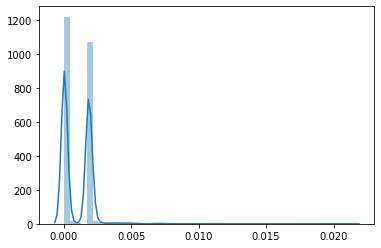

-----
running fold 2...
Train on 16000 samples, validate on 4000 samples
Epoch 1/40
16000/16000 [==============================] - 22s 1ms/step - loss: 0.0532 - f1: 1.4815e-04 - val_loss: 0.0135 - val_f1: 0.0000e+00
Epoch 2/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0168 - f1: 0.0000e+00 - val_loss: 0.0137 - val_f1: 0.0000e+00
Epoch 3/40
16000/16000 [==============================] - 17s 1ms/step - loss: 0.0168 - f1: 0.0000e+00 - val_loss: 0.0131 - val_f1: 0.0000e+00
Epoch 4/40
4000/4000 [==============================] - 1s 196us/step
logloss on train set 0.014761503570381319
logloss on test set 0.00395986114894913
Check f1 on train set:
Best threshold:  0.0045420825
Best F1-Score:  nan

Check f1 on test set:
Best threshold:  0.0015732348
Best F1-Score:  nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


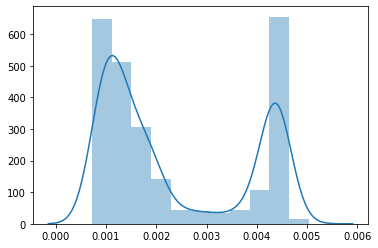

-----
running fold 3...
Train on 16000 samples, validate on 4000 samples
Epoch 1/40
16000/16000 [==============================] - 24s 1ms/step - loss: 0.0401 - f1: 0.0000e+00 - val_loss: 0.0174 - val_f1: 0.0000e+00
Epoch 2/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0161 - f1: 0.0000e+00 - val_loss: 0.0165 - val_f1: 0.0000e+00
Epoch 3/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0166 - f1: 0.0000e+00 - val_loss: 0.0159 - val_f1: 0.0000e+00
Epoch 4/40
4000/4000 [==============================] - 1s 194us/step
logloss on train set 0.016334050145840592
logloss on test set 0.0027644824552116917
Check f1 on train set:
Best threshold:  0.0017318726
Best F1-Score:  nan

Check f1 on test set:
Best threshold:  0.00021639466
Best F1-Score:  nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


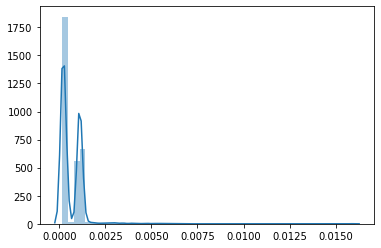

-----
running fold 4...
Train on 16000 samples, validate on 4000 samples
Epoch 1/40
16000/16000 [==============================] - 23s 1ms/step - loss: 0.0413 - f1: 0.0000e+00 - val_loss: 0.0161 - val_f1: 0.0000e+00
Epoch 2/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0157 - f1: 0.0000e+00 - val_loss: 0.0164 - val_f1: 0.0000e+00
Epoch 3/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0166 - f1: 0.0000e+00 - val_loss: 0.0162 - val_f1: 0.0000e+00
Epoch 4/40
4000/4000 [==============================] - 1s 207us/step
logloss on train set 0.0156388038486868
logloss on test set 0.0027111460141240966
Check f1 on train set:
Best threshold:  0.005119294
Best F1-Score:  nan

Check f1 on test set:
Best threshold:  0.0011409521
Best F1-Score:  nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


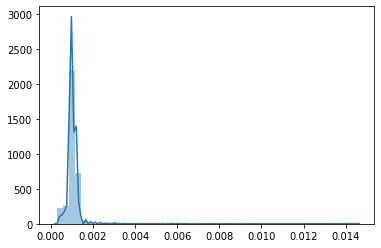

-----
running fold 5...
Train on 16000 samples, validate on 4000 samples
Epoch 1/40
16000/16000 [==============================] - 24s 1ms/step - loss: 0.0309 - f1: 0.0000e+00 - val_loss: 0.0172 - val_f1: 0.0000e+00
Epoch 2/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0160 - f1: 0.0000e+00 - val_loss: 0.0168 - val_f1: 0.0000e+00
Epoch 3/40
16000/16000 [==============================] - 18s 1ms/step - loss: 0.0165 - f1: 0.0000e+00 - val_loss: 0.0163 - val_f1: 0.0000e+00
Epoch 4/40
4000/4000 [==============================] - 1s 204us/step
logloss on train set 0.015318004435497279
logloss on test set 0.003627147492741642
Check f1 on train set:
Best threshold:  0.0059008896
Best F1-Score:  nan

Check f1 on test set:
Best threshold:  0.000706166
Best F1-Score:  nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


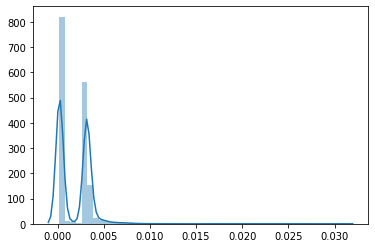

-----


In [29]:
num_folds = 5
using_SMOTE = True
kfolds = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
error_logs = []
counter= 1

for trainIdx, testIdx in kfolds.split(X_train, y_train):

    print(f"running fold {counter}...")
    # create callbacks
    model_path = 'best_model_fold'+str(counter)+'.h5'
    mc = ModelCheckpoint(model_path, monitor='val_f1', mode='min', verbose=-1, save_best_only=True)
    es = EarlyStopping(monitor='val_f1', min_delta=0, patience=3, verbose=-1)
    # create model
    model = create_model_1()
    model.fit(X_train[trainIdx], y_train[trainIdx], validation_data=(X_train[testIdx], y_train[testIdx]), batch_size=32, epochs=40, callbacks=[mc, es], verbose =1)
    # Done load the best model of this fold
#     saved_model = load_model(model_path)
    model.load_weights(filepath = model_path)

    error_logs.append({'path': model_path, 'train_f1': model.evaluate(X_train[testIdx], y_train[testIdx])})
    counter = counter + 1
    
    y_train_pred = model.predict(X_train)[:,0]
    y_test_pred = model.predict(X_test)[:,0]
    
    print(f"logloss on train set {log_loss(y_train, y_train_pred)}")
    print(f"logloss on test set {log_loss(y_test, y_test_pred)}")
    
    print("Check f1 on train set:")
    max_f1(X_train, y_train, y_train_pred)
    
    print("\nCheck f1 on test set:")
    max_f1(X_test, y_test, y_test_pred)
    
    f = sns.distplot(y_test_pred)
    plt.show(f)
    print("-----")

In [30]:
error_logs

[{'path': 'best_model_fold1.h5', 'train_f1': [0.014205727028893307, 0.0]},
 {'path': 'best_model_fold2.h5', 'train_f1': [0.013512034346349537, 0.0]},
 {'path': 'best_model_fold3.h5', 'train_f1': [0.01742075359914452, 0.0]},
 {'path': 'best_model_fold4.h5', 'train_f1': [0.016118502792902292, 0.0]},
 {'path': 'best_model_fold5.h5', 'train_f1': [0.01722465949365869, 0.0]}]

In [31]:
model = create_model_1()
for md in error_logs:
    model.load_weights(filepath = md['path'])
    print(model.evaluate(X_test, y_test))

4000/4000 [==============================] - 2s 501us/step
[0.003419107172638178, 0.0]
4000/4000 [==============================] - 1s 201us/step
[0.003959861434064805, 0.0]
4000/4000 [==============================] - 1s 208us/step
[0.0027644829656928776, 0.0]
4000/4000 [==============================] - 1s 214us/step
[0.0027111461604945363, 0.0]
4000/4000 [==============================] - 1s 198us/step
[0.0036271473160013556, 0.0]


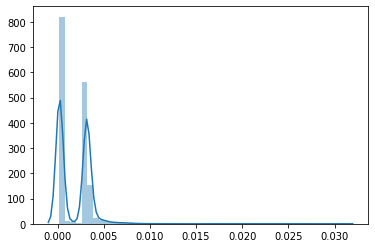

In [32]:
sns.distplot(y_test_pred)